<a href="https://colab.research.google.com/github/Zhuoyue-Huang/urop_2022_ml/blob/main/FE_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [272]:
"""Verify the gradient derivation of linear masked autoencoder."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np
from torch.distributions.exponential import Exponential

In [273]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [274]:
# set default to be float64
torch.set_default_dtype(torch.float64)

### Model initialisation

In [275]:
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, x_dim, scale_val=0, device='cuda'):
    return torch.zeros(sample_num, x_dim, device=device).bernoulli_(prob)*(1-scale_val) + scale_val

def mask_probs(prob_list: torch.Tensor, sample_num, x_dim, scale_val=0, device='cuda'):
    return torch.zeros(sample_num, x_dim, device=device).bernoulli_(prob_list)*(1-scale_val) + scale_val

# def mask_patches_block(prob, patch_size: torch.Tensor, sample_num, sample_dim: torch.Tensor, device='cuda'):
#     x_dim = sample_dim[0]*sample_dim[1]
#     div_check = sample_dim % patch_size == torch.zeros(2)
#     if torch.all(div_check):
#         pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
#         mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob).to(device)
#         mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
#         return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, x_dim)
#     else:
#         raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")

def mask_patches_plain(prob, patch_size, sample_num, x_dim, scale_val=0, device='cuda'):
    if not x_dim % patch_size:
        pix_num = x_dim // patch_size
        mat_patches = torch.zeros(sample_num, pix_num).bernoulli_(prob)
        return mat_patches.repeat_interleave(patch_size, dim=1).to(device)*(1-scale_val) + scale_val
    else:
        raise NotImplementedError

In [276]:
def feature_extraction(data_dict, f_dim, criterion, model_type, prob=None, prob_list=None, patch_size=None, scale_val=0, mask_val=0, data_type='val', device='cuda'):
    X_train, y_train, X_val, y_val, X_test, y_test = data_dict.values()
    train_num, x_dim = X_train.shape
    val_num = X_val.shape[0]
    y_dim = y_train.shape[1]
    if model_type == 'LAE':
        Sigma = X_train.T @ X_train
        U, _, _ = torch.linalg.svd(Sigma)
        U = U[:, :f_dim]
        W1 = U.T 
        W2 = U
        loss = criterion(X_val@W1.T@W2.T, X_val)
    else:
        X = X_train
        if prob == 1 or scale_val==1:
            Sigma = X.T@X
            U, _, _ = torch.linalg.svd(Sigma)
            U = U[:, :f_dim]
            W1 = U.T
            W2 = U
            loss = criterion(X_val@W1.T@W2.T, X_val)
        else:
            mask_dict = {}
            if model_type == 'MLAE_basic':
                first_moment = prob + scale_val * (1-prob)
                second_moment = prob + scale_val**2 * (1-prob)
                second_moment_reverse = 1-prob + scale_val**2 * prob
                mask_dict['mean'] = (torch.ones(train_num, x_dim, device=device) * first_moment)
                mask_dict['square'] = torch.ones(x_dim, x_dim, device=device) * first_moment**2
                mask_dict['square'].fill_diagonal_(second_moment)

                x0_sum = torch.sum(X, 0, keepdim=True).repeat(x_dim, 1)
                mask_x = torch.diag(torch.ones(x_dim, device=device))
                mean_reverse = mask_x*(first_moment-second_moment)+(1-mask_x)*first_moment*(1-first_moment)
                square_reverse = torch.ones(x_dim, x_dim, device=device) * (1-first_moment)**2
                square_reverse.fill_diagonal_(second_moment_reverse)
                mask_dict['var_increment'] = mask_val*(x0_sum+x0_sum.T)*mean_reverse + (mask_val**2)*train_num*square_reverse

            elif model_type == 'MLAE_probs':
                first_moment = prob_list + scale_val * (1-prob_list)
                second_moment = prob_list + scale_val**2 * (1-prob_list)
                second_moment_reverse = 1-prob_list + scale_val**2*prob_list
                mask_dict['mean'] = first_moment.repeat(train_num, 1).to(device)
                mask_dict['square'] = first_moment.view(x_dim, 1) @ first_moment.view(1, x_dim)
                mask_dict['square'] = (mask_dict['square'].fill_diagonal_(0) + torch.diag(second_moment)).to(device)
                
                x0_sum = torch.sum(X, 0, keepdim=True).repeat(x_dim, 1)
                p_mat = first_moment.repeat(x_dim, 1).to(device)
                mask_x = torch.diag(torch.ones(x_dim, device=device))
                mean_reverse = torch.diag(first_moment-second_moment).to(device)+(1-mask_x)*(1-p_mat.T)*p_mat
                square_reverse = (1-first_moment).view(x_dim, 1) @ (1-first_moment).view(1, x_dim)
                square_reverse = (square_reverse.fill_diagonal_(0) + torch.diag(second_moment_reverse)).to(device)
                mask_dict['var_increment'] = mask_val*mean_reverse*x0_sum + mask_val*mean_reverse.T*x0_sum.T*mask_x + (mask_val**2)*train_num*square_reverse
                
            elif model_type == 'MLAE_patches':
                first_moment = prob + scale_val * (1-prob)
                second_moment = prob + scale_val**2 * (1-prob)
                second_moment_reverse = 1-prob + scale_val**2 * prob
                mask_dict['mean'] = torch.ones(train_num, x_dim, device=device) * first_moment
                # plain patches
                patch_block_mat = torch.ones(patch_size, patch_size, device=device)
                mask_dict['square'] = torch.block_diag(*[patch_block_mat]*(x_dim//patch_size))*(second_moment-first_moment**2) + first_moment**2

                x0_sum = torch.sum(X, 0, keepdim=True).repeat(x_dim, 1)
                mask_x = torch.block_diag(*[patch_block_mat]*(x_dim//patch_size))
                mean_reverse = mask_x*(first_moment-second_moment) + (1-mask_x)*first_moment*(1-first_moment)
                square_reverse = torch.block_diag(*[patch_block_mat]*(x_dim//patch_size))*(second_moment_reverse-(1-first_moment)**2) + (1-first_moment)**2
                mask_dict['var_increment'] = mask_val*(x0_sum+x0_sum.T)*mean_reverse + (mask_val**2)*train_num*square_reverse
                # block patches
                # patch_size = [2, 2]
                # pix_num = torch.div(torch.tensor(sample_dim), torch.tensor(patch_size), rounding_mode='floor')
                # mat_patches = torch.arange(pix_num[0]*pix_num[1]).view(*pix_num)
                # mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=1)
                # mat_patches = torch.repeat_interleave(mat_patches, patch_size[0], dim=0).view(n)
                # mask_dict['square'] = torch.zeros(x_dim, x_dim)
                # for i in range(x_dim):
                #     for j in range(x_dim):
                #         if mat_patches[i] == mat_patches[j]:
                #             mask_dict['square'][i, j] = prob
                #         else:
                #             mask_dict['square'][i, j] = prob**2
            try:
                inv = torch.inverse(mask_dict['square']*(X.T@X) + mask_dict['var_increment'])
            except torch._C._LinAlgError:
                # Sigma_XX = X.T@X
                # U_XX, S_XX, Vh_XX = torch.linalg.svd(Sigma_XX)
                # print(S_XX)
                # inv = Vh_XX.T*torch.inverse(torch.diag(S_XX+1e-4))*U_XX.T

                perturbation = torch.diag(torch.ones(x_dim, device=device)*1e-20)
                inv = torch.inverse(mask_dict['square']*(X.T@X) + mask_dict['var_increment'] + perturbation)
            Sigma = X.T@(mask_dict['mean']*X+(1-mask_dict['mean'])*mask_val) @ inv @ ((mask_dict['mean']*X+(1-mask_dict['mean'])*mask_val).T@X)
            U, _, _ = torch.linalg.svd(Sigma)
            U = U[:, :f_dim]
            W1 = U.T @ (X.T@(mask_dict['mean']*X+(1-mask_dict['mean'])*mask_val)) @ inv
            W2 = U
            if model_type == 'MLAE_basic':
                loss = criterion((mask_basic(prob, val_num, x_dim, scale_val=scale_val)*X_val)@W1.T@W2.T, X_val)
            elif model_type == 'MLAE_probs':
                loss = criterion((mask_probs(prob_list, val_num, x_dim, scale_val=scale_val)*X_val)@W1.T@W2.T, X_val)
            elif model_type == 'MLAE_patches':
                loss = criterion((mask_patches_plain(prob, patch_size, val_num, x_dim, scale_val=scale_val)*X_val)@W1.T@W2.T, X_val)
    if data_type == 'val':
        test_X = X_val
        test_y = y_val
    elif data_type == 'test':
        test_X = X_test
        test_y = y_test
    
    f_train = X_train @ W1.T
    f_test = test_X @ W1.T

    return {'f_train': f_train, 'y_train': y_train, 'f_test': f_test, 'y_test': test_y}

In [277]:
# representation learning
def repr_learning(fe_dict, criterion, reg_coeff=0, device='cuda'):
    f_train, y_train, f_test, y_test = fe_dict.values()

    theta = (torch.inverse(f_train.T@f_train+reg_coeff*torch.eye(f_dim, device=device)) @ f_train.T @ y_train).T
    loss = criterion(y_test, f_test @ theta.T)
    return loss.item()

### Dataset

In [278]:
train_num, val_num, test_num = (4000, 500, 2000) # larger number of dataset
sample_num_split = (train_num, train_num + val_num)
total = train_num+val_num+test_num

# need to consider f_dim <, =, > z_dim
z_dim = 30 # dimension of z
H = 8
W = 8
sample_dim = torch.tensor([H, W])
x_dim = H * W
f_dim = 15
y_dim = z_dim // 2

prob_search = torch.arange(0.01, 1+0.01, 0.01)
prob_list_search = torch.rand(x_dim, generator=torch.random.manual_seed(1911))*0.1 + torch.repeat_interleave(torch.arange(0.01, 0.9+0.01, 0.01).unsqueeze(1), x_dim, dim=1)
patch_size_plain_search = torch.tensor([1, 2, 4, 8, 16])
# patch_size_block_search = []
# for i in [1, 2, 4, 8, 16]:
#     for j in [1, 2, 4, 8, 16]:
#         patch_size_block_search.append([i, j])
# patch_size_search = torch.tensor(patch_size_block_search)

In [279]:
#mean = torch.linspace(0, 5, z_dim).repeat(total, 1)
#std = torch.linspace(3, 8, z_dim).repeat(total, 1)
#m = Exponential(1)
#z = m.rsample((total,z_dim))
#z = torch.normal(mean=mean, std=std, generator=torch.random.manual_seed(1911))
z = torch.normal(mean=10, std=1, size=(total,z_dim), generator=torch.random.manual_seed(1911))# here distribution is high dimensional guassian
z = z.to(device)

In [280]:
U = torch.rand(x_dim, z_dim, generator=torch.random.manual_seed(1911))*2-1
U = U.to(device)
V = torch.rand(y_dim, z_dim, generator=torch.random.manual_seed(1911))*2-1
V = V.to(device)

x = z @ U.T
print(torch.mean(x))
y = z @ V.T
X_train, X_val, X_test = torch.tensor_split(x, sample_num_split)
y_train, y_val, y_test = torch.tensor_split(y, sample_num_split)
data_dict = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test}
fe_loss_dict = {'LAE': [], 'MLAE_basic': [], 'MLAE_probs': [], 'MLAE_patches': [], 'PCA': []}

tensor(-8.8410, device='cuda:0')


In [281]:
criterion = nn.MSELoss()
rand_epoch = 1
reg_coeff = 1
mask_val = 0.2

### Get features from autoencoder

##### Linear autoencoder

In [282]:
fe_dict = feature_extraction(data_dict, f_dim, criterion, data_type='test', model_type='LAE')
reg_loss = repr_learning(fe_dict, criterion, reg_coeff=reg_coeff)
fe_loss_dict['LAE'].append(reg_loss)
print('Regression loss:', reg_loss)

Regression loss: 2.713081965106139


In [283]:
#print('mean:', statistics.mean(fe_loss_dict['LAE']), ', sd:', statistics.stdev(fe_loss_dict['LAE']))

##### Masked linear autoencoder (basic)

In [284]:
# grid search
search_record = {'params': -1, 'best_score': 1e8, 'index': 0}
search_score = []
for index, prob in enumerate(prob_search):
    total_loss = 0
    for i in range(rand_epoch):
        fe_dict = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_basic', prob=prob, mask_val=mask_val)
        reg_loss = repr_learning(fe_dict, criterion, reg_coeff=reg_coeff)
        total_loss += reg_loss
    loss = total_loss / rand_epoch
    search_score.append(loss)
    if loss < search_record['best_score']:
        search_record['best_score'] = loss
        search_record['params'] = prob
        search_record['index'] = index

In [285]:
prob = round(search_record['params'].item(), 2)
loss = search_record['best_score']
index = search_record['index']
print('prob:', prob, '\nloss:', loss)

prob: 0.99 
loss: 2.5730966796650514


Text(tensor(0.9405), 2.598827646461702, 'prob=0.99')

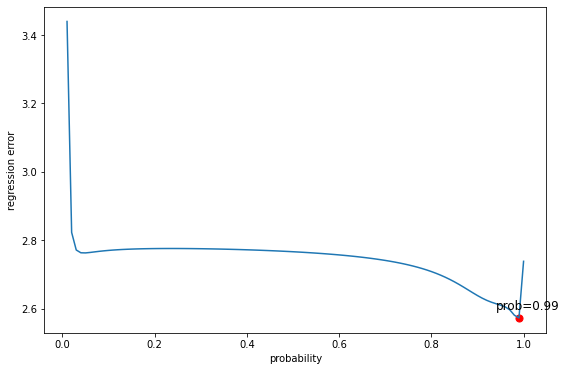

In [286]:
# search check
plt.figure(figsize=(9, 6))
plt.plot(prob_search, search_score)
plt.xlabel('probability')
plt.ylabel('regression error')
plt.scatter(prob_search[index], loss, s=50, color="red")
plt.text(prob_search[index]*(1-0.05), loss*(1+0.01), f'prob={prob}', fontsize=12)

In [287]:
for i in range(rand_epoch):
    fe_dict = feature_extraction(data_dict, f_dim, criterion, data_type='test', model_type='MLAE_basic', prob=prob)
    reg_loss = repr_learning(fe_dict, criterion, reg_coeff=reg_coeff)
    fe_loss_dict['MLAE_basic'].append(reg_loss)
print('Regression loss:', np.mean(fe_loss_dict['MLAE_basic']))

Regression loss: 2.5812626092182045


In [288]:
#print('mean:', statistics.mean(fe_loss_dict['MLAE_basic']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_basic']))

##### Masked linear autoencoder (probs)

In [289]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8, 'index': 0}

for index, prob_list in enumerate(prob_list_search):
    total_loss = 0
    for i in range(rand_epoch):
        fe_dict = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_probs', prob_list=prob_list, mask_val=mask_val)
        reg_loss = repr_learning(fe_dict, criterion, reg_coeff=reg_coeff)
        total_loss += reg_loss
    loss = total_loss / rand_epoch
    search_score.append(loss)
    if loss < search_record['best_score']:
        search_record['best_score'] = loss
        search_record['params'] = prob_list
        search_record['index'] = index

In [290]:
prob_list = search_record['params']
loss = search_record['best_score']
index = search_record['index']
prob = round(prob_search[index].item(), 2)
print('prob:', prob, '\nloss:', loss)

prob: 0.85 
loss: 2.7331991779032814


Text(tensor(0.8075), 2.7605311696823143, 'prob=0.85')

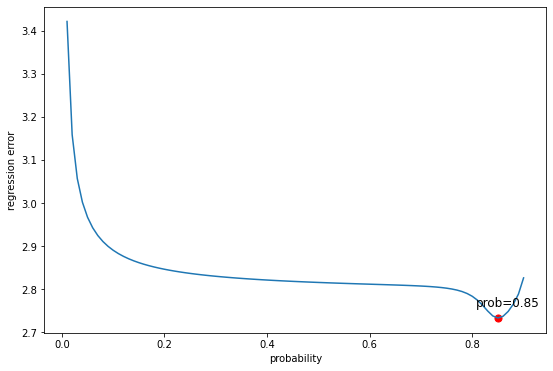

In [291]:
# search check
plt.figure(figsize=(9, 6))
plt.plot(prob_search[:90], search_score)
plt.xlabel('probability')
plt.ylabel('regression error')
plt.scatter(prob_search[index], loss, s=50, color="red")
plt.text(prob_search[index]*(1-0.05), loss*(1+0.01), f'prob={prob}', fontsize=12)

In [292]:
for i in range(rand_epoch):
    fe_dict = feature_extraction(data_dict, f_dim, criterion, data_type='test', model_type='MLAE_probs', prob_list=prob_list)
    reg_loss = repr_learning(fe_dict, criterion, reg_coeff=reg_coeff)
    fe_loss_dict['MLAE_probs'].append(reg_loss)
print('Regression loss:', np.mean(fe_loss_dict['MLAE_probs']))

Regression loss: 2.787484747206054


In [293]:
#print('mean:', statistics.mean(fe_loss_dict['MLAE_probs']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_probs']))

##### Masked linear autoencoder (patches)

In [294]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8, 'index': 0}

for index, prob in enumerate(prob_search):
    for patch_size in patch_size_plain_search:
        total_loss = 0
        for i in range(rand_epoch):
            fe_dict = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_patches', prob=prob, patch_size=patch_size, mask_val=mask_val)
            reg_loss = repr_learning(fe_dict, criterion, reg_coeff=reg_coeff)
            total_loss += reg_loss
        loss = total_loss / rand_epoch
        search_score.append(loss)
        if loss < search_record['best_score']:
            search_record['best_score'] = loss
            search_record['params'] = (prob, patch_size)
            search_record['index'] = index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: __rfloordiv__ is deprecated, and its b

In [295]:
prob = round(search_record['params'][0].item(), 2)
patch_size = search_record['params'][1]
loss = search_record['best_score']
index = search_record['index']
print('prob:', prob, '\npatch size:', patch_size, '\nloss:', loss)

prob: 0.72 
patch size: tensor(4) 
loss: 2.5309582889787015


Text(tensor(0.6840), 2.5562678718684886, 'prob=0.72')

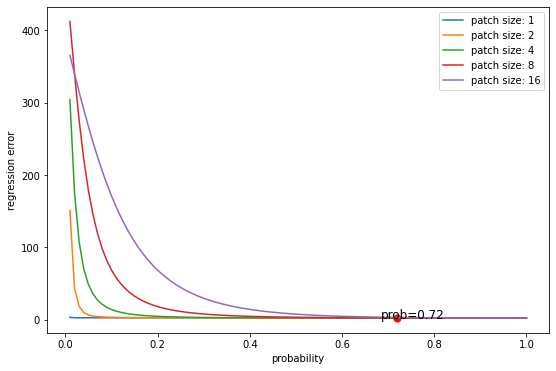

In [296]:
# search check
plt.figure(figsize=(9, 6))
len_loop = len(patch_size_plain_search)
for i in range(len_loop):
    plt.plot(prob_search, search_score[i::len_loop])
plt.legend([f'patch size: {patch_size}' for patch_size in patch_size_plain_search])
plt.xlabel('probability')
plt.ylabel('regression error')
plt.scatter(prob_search[index], loss, s=50, color="red")
plt.text(prob_search[index]*(1-0.05), loss*(1+0.01), f'prob={prob}', fontsize=12)

In [297]:
for i in range(rand_epoch):
    fe_dict = feature_extraction(data_dict, f_dim, criterion, data_type='test', model_type='MLAE_patches', prob=prob, patch_size=patch_size)
    reg_loss = repr_learning(fe_dict, criterion, reg_coeff=reg_coeff)
    fe_loss_dict['MLAE_patches'].append(reg_loss)
print('Regression loss:', np.mean(fe_loss_dict['MLAE_patches']))

Regression loss: 2.5390170670106667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: __rfloordiv__ is deprecated, and its b

In [298]:
#print('mean:', statistics.mean(fe_loss_dict['MLAE_patches']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_patches']))

### Get features from unsupervised learning

##### PCA

In [299]:
# feature extraction
U, S, V = torch.pca_lowrank(X_train, q=f_dim)
fe_dict = {'f_train': X_train@V, 'y_train': y_train, 'f_test': X_test@V, 'y_test': y_test}
reg_loss = repr_learning(fe_dict, criterion, reg_coeff=reg_coeff)
fe_loss_dict['PCA'].append(reg_loss)
print('Regression loss:', np.mean(fe_loss_dict['PCA']))

Regression loss: 2.7167164113730706


### Evaluation

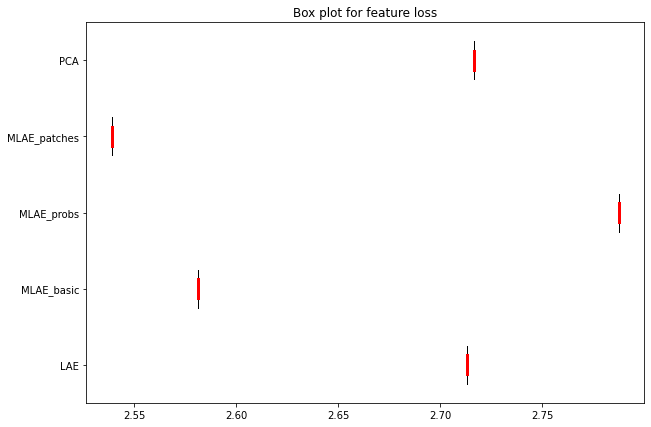

In [300]:
data = fe_loss_dict.values()
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF', '#00FFFF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(fe_loss_dict.keys())
#ax.set_yticklabels(patch_dict.keys())
 
# Adding title
plt.title("Box plot for feature loss")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()